# P1: Modelado de un vehículo

# P2: Segimiento de Caminos

# P3: SLAM basado en EFK

P4: Evitar Obstáculos

P5: Planificación de Caminos - Dijkstra

P6: Planificación de Caminos - A*

P7: Navegación Autónoma


<div style="color: red;">

- Reducir la imagen del enunciado para que quepa en una página
- Pendiente comentar la función
- La variable max_rango parece que sobra
    
    
</div>

\newpage

# Evitar Obstáculos

Se pretende desarrollar un módulo de navegación local o reactiva capaz de evitar obstáculos en tiempo real a partir de las lecturas de los sensores de a bordo de un robot móvil, mientras éste navega desde una posición inicial hasta su destino.

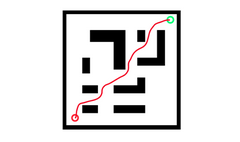

Dado que se requiere un módulo de navegación reactiva que funcione en tiempo real, que calcule el movimiento del robot en tiempo de ejecución, se plantea la implementación del método de campos potenciales en su versión más apropiada para tiempo real. Es decir, calcular únicamente las fuerzas de atracción y repulsión sobre el robot y no sobre todo el entorno que le rodea. Por tanto, dada una distribución de obstáculos y lecturas del sensor, en cada iteración tendrán que calcularse únicamente las fuerzas de atracción (al objetivo) y repulsión (de los obstáculos) en la ubicación donde se encuentre el robot en cada instante:

$$\vec F_{res} (q) = \vec F_{atr} (q) + \sum \vec F_{rep} (q) \tag {4.1}$$
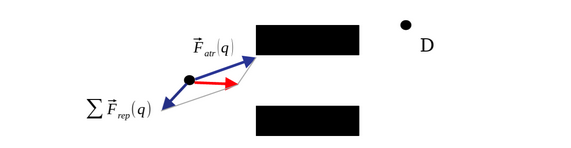

Como primera propuesta se plantea realizar la implementación del algoritmo en Matlab, de forma que la información del entorno local que captan los sensores del robot se carguen a partir de una imagen. Esta imagen y un script a modo de plantilla se proporcionan con el material de prácticas. Los archivos que se proporcionan son:

- **mapa1_150.pn**. Imagen que simula un mapa con los obstáculos del entorno.
- **plantilla_campos_potenciales.m**. Como se indica en los comentarios de dicha plantilla hay que completar el movimiento del robot calculado a partir de las fuerzas a las que está sometido por el destino y los obstáculos y, antes de realizar estos cálculos en el bucle, crear una lista con los obstáculos.

\newpage

## Ejercicio

Completar el script denominado plantilla para conseguir la navegación reactiva del robot según el método de campos potenciales. 

### Implmentación

Las adaptaciones realizadas al código son las siguientes:

1. Cálculo de la fuerza de atracción fAtr en función del parámetro alfa
2. Cálculo de la fuerza de repulsión utilizando la función ray Intersection que devuelve las ditancias alrededor del robot en los ángulos proporcionados como argumento
3. Actualización de la posición del robot a partir de la suma de fuerzas y de la velocidad

```C
   %// Fuerza de atracción
   robXY = robot(1:2);
   fAtr = alfa * (destino - robXY);

   %// Fuerza de repulsión
   fRep = 0;
   Obstaculos = rayIntersection(mapa, robot, angulos, D);
   nObs = length(Obstaculos);
   if (nObs > 0)
       for i = 1:nObs
           if not (isnan(Obstaculos(i,1)))
               delta = robXY-Obstaculos(i, :);
               distObs = norm(delta);
               fRep = fRep+ beta*((1/distObs)-1/D)*(delta)/(distObs^3);
           end
       end
   end

   %// Suma de fuerzas y actualización de posición y orientación
   fRes = fAtr + fRep;
   fRes = fRes / norm(fRes);
   robXY = robXY + v * fRes;
   robot = [robXY(1), robXY(2), atan2(robXY(2), robXY(1))];

   %// Fin código modificado
```

\newpage

A partir de la plantilla proporcionada definimos una función que nos permita realizar pruebas cambiaando los parámetros de entrada

**CamposPotenciales.m**
```C
function [iteracion] = CamposPotenciales(fich_mapa, v, D, alfa, beta)

%CamposPotenciales('mapa1_150.png', 0.4, 1.5, 1, 100)
%// fich_mapa;
%// v=0.4;        % Velocidad del robot
%// D=1.5;        % Rango del efecto del campo de repulsión de los obstáculos
%// alfa=1;       % Coeficiente de la componente de atracción
%// beta=100;     % Coeficiente de la componente de repulsión

%% Carga del mapa de ocupacion
map_img=imread(fich_mapa);
map_neg=imcomplement(map_img);
map_bin=imbinarize(map_neg);
mapa=binaryOccupancyMap(map_bin);
show(mapa);

% Marcar los puntos de inicio y destino
hold on;
title('Señala los puntos inicial y final de la trayectoria del robot');
origen=ginput(1);
plot(origen(1), origen(2), 'go','MarkerFaceColor','green');  % Dibujamos el origen
destino=ginput(1);
plot(destino(1), destino(2), 'ro','MarkerFaceColor','red');  % Dibujamos el destino
% Configuracion del sensor (laser de barrido)
%! max_rango=10;
angulos=-pi/2:(pi/180):pi/2; % resolucion angular barrido laser

fmt = "v=%0.1f, D=%0.1f, alfa=%0.1f, beta=%0.1f";
title(sprintf(fmt, v, D, alfa, beta));


%% Inicialización

robot=[origen 0];     % El robot empieza en la posición de origen (orientacion cero)
path = [];            % Se almacena el camino recorrido
path = [path; robot]; % Se añade al camino la posicion actual del robot
iteracion=0;          % Se controla el nº de iteraciones por si se entra en un minimo local

%% Calculo de la trayectoria

while norm(destino-robot(1:2)) > v && iteracion<1000    % Hasta menos de una iteración de la meta (10 cm)
   %// INICIO CAMBIOS
   %// Fuerza de atracción
   robXY = robot(1:2);
   fAtr = alfa * (destino - robXY);

   %// Fuerza de repulsión
   fRep = 0;
   Obstaculos = rayIntersection(mapa, robot, angulos, D);
   nObs = length(Obstaculos);
   if (nObs > 0)
       for i = 1:nObs
           if not (isnan(Obstaculos(i,1)))
               delta = robXY-Obstaculos(i, :);
               distObs = norm(delta);
               fRep = fRep+ beta*((1/distObs)-1/D)*(delta)/(distObs^3);
           end
       end
   end

   %// Suma de fuerzas y actualización de posición y orientación
   fRes = fAtr + fRep;
   fRes = fRes / norm(fRes);
   robXY = robXY + v * fRes;
   robot = [robXY(1), robXY(2), atan2(robXY(2), robXY(1))];

   %// Fin código modificado

    path = [path;robot];	% Se añade la nueva posición al camino seguido
    plot(path(:,1),path(:,2),'r');
    drawnow

    iteracion=iteracion+1;
end

if iteracion==1000   % Se ha caído en un mínimo local
    fprintf('No se ha podido llegar al destino.\n')
else
    fprintf('Destino alcanzado.\n')
end

end
```

\newpage

### Pruebas

Realizamos distintas pruebas con la configuración de parámetros por defecto y vemos que el algoritmo funciona correctamente

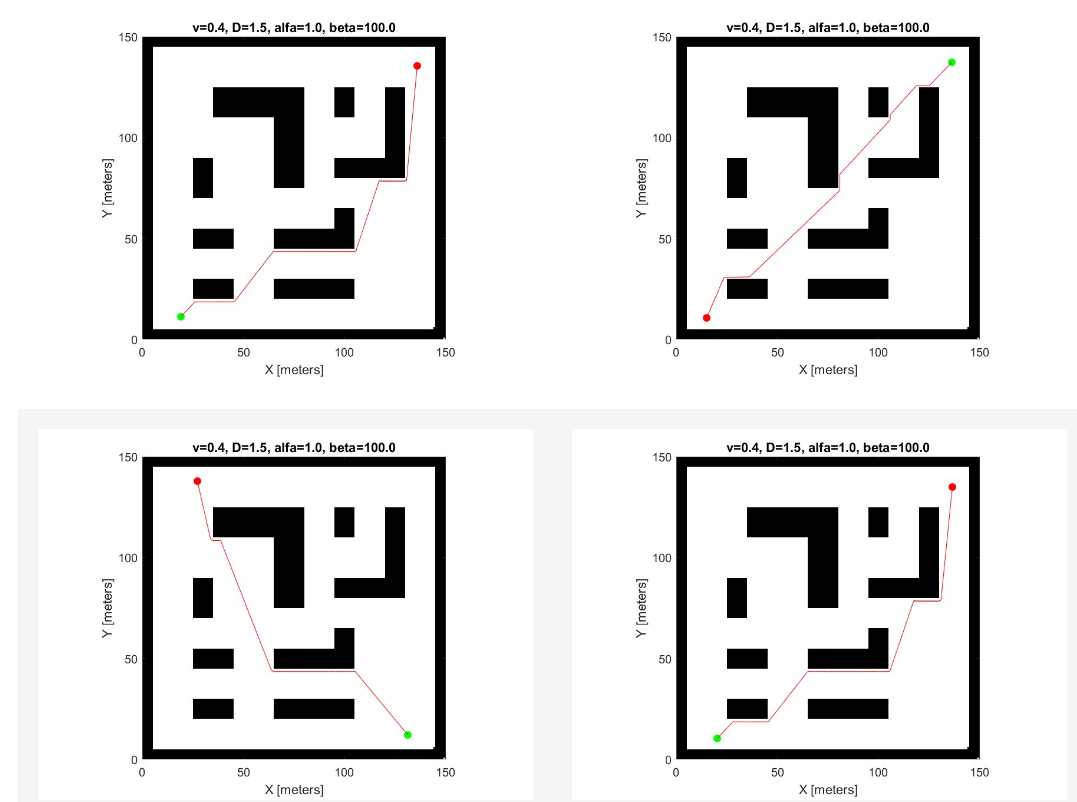

\newpage

## Ejercicio

Realizar varios experimentos con diferentes orígenes y destinos. Cambiar los parámetros del método, como α y β, o cualquier otro, para tratar de mejorar la situación. Poner el destino y origen en una situación de mínimo local (situación de trampa local), ¿es posible que el método pueda encontrar la solución sin modificarlo y cambiando solo los parámetros anteriormente mencionados?.

### Modificar el rango D

Dependiendo de dónde situemos el origen, puede ocurrir que el algoritmo no funcione correctamente (atraveando algún obstáculos).  Una forma de resolverlo es aumentar el rango de efecto del campo (en la imagen, D pasa de 1.5 a 3.0), aunque esta solución aumenta el coste computacional

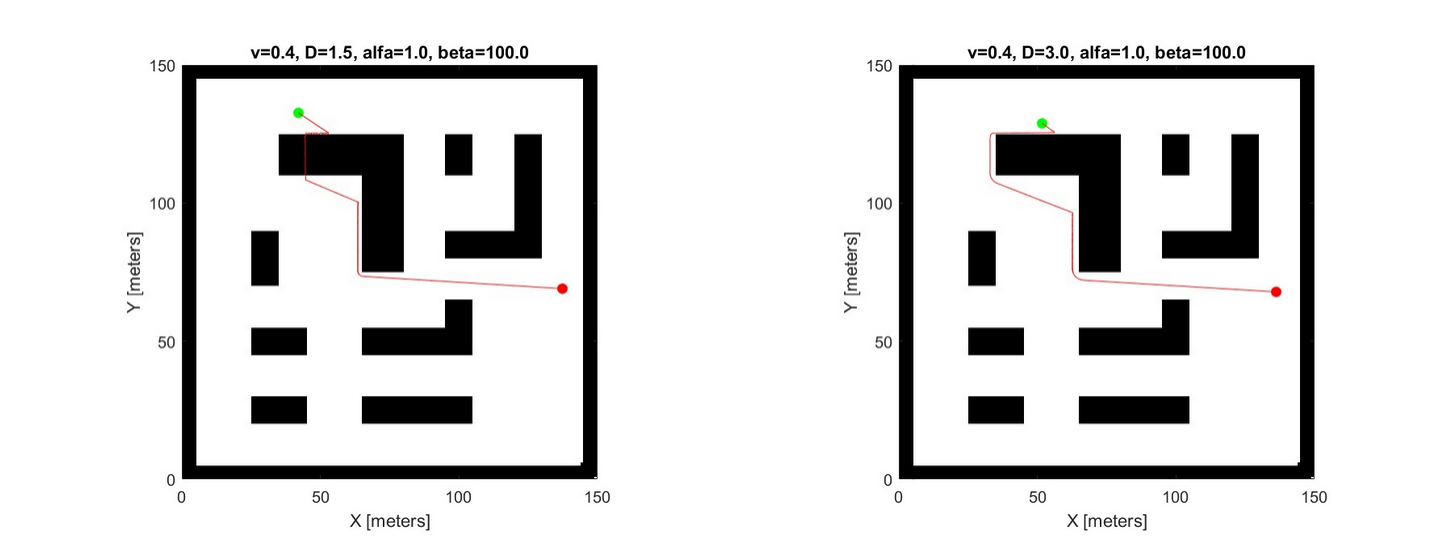


### Modificar el parámetro beta

Intentamos resolver el problema modificando el parámetro beta:

- Al aumentarlo (beta=200), la fuerza de repulsión se incrementa y le cuesta más atravesar el obstáculo.
- Al disminuirlo (beta=50), la fuerza se reduce y es más probable que atraviese el obstáculo

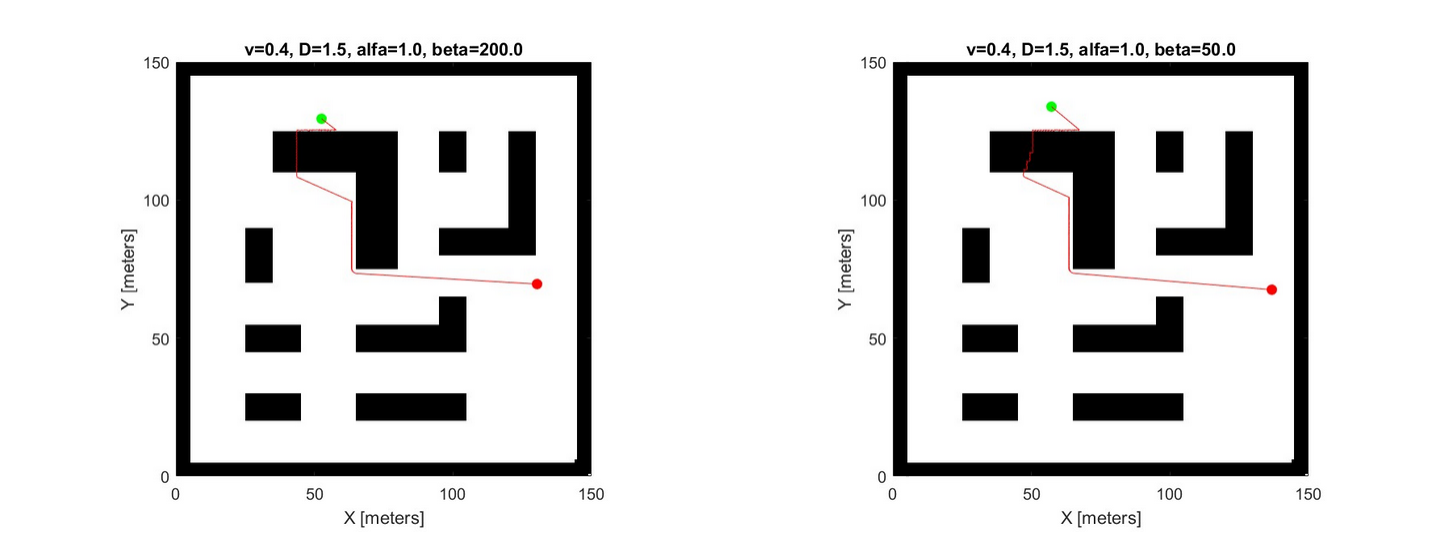

\newpage


### Modificar la velocidad

Intentamos resolver el problema modificando la velocidad:

- Al aumentar la velocidad (0.8), la probabilidad de entrar en el obstáculo crece
- Al disminuirla (0.2), la trayectoria ya consigue evitar el obstáculo, pero no da tiempo a llegar al final de la trayectoria

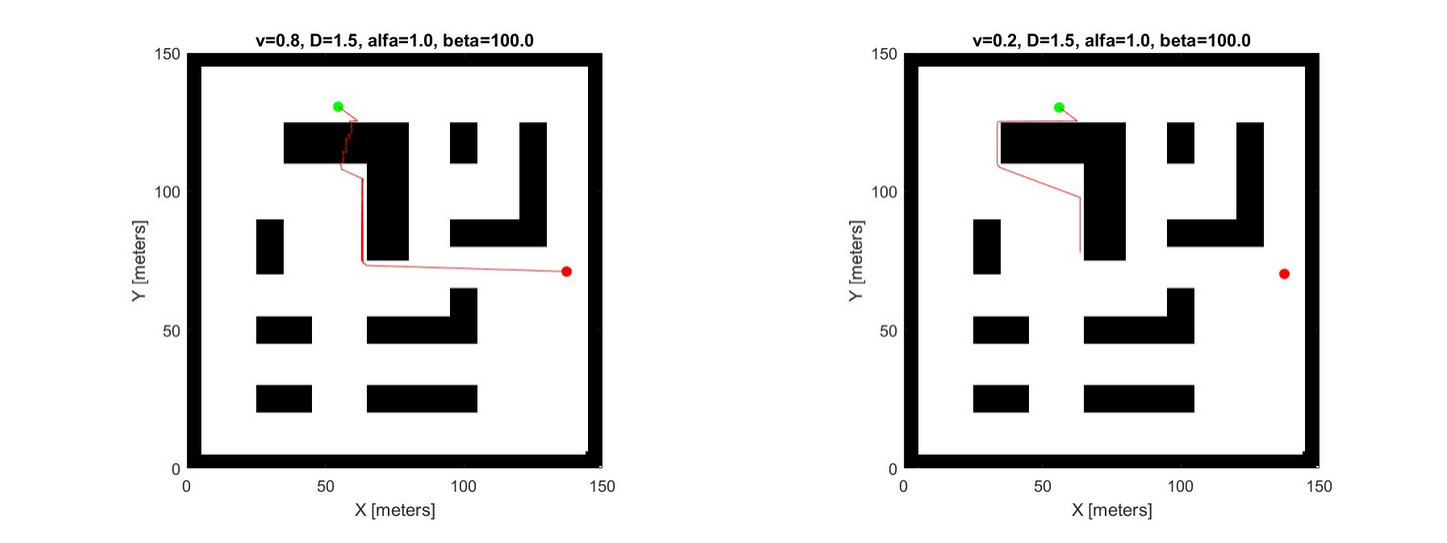

### Modificar el parámetro alfa

Reduciendo el parámetro alfa se consigue un efecto similar a reducir la velocidad, pero  en este caso sí se consigue terminar la trayectoria

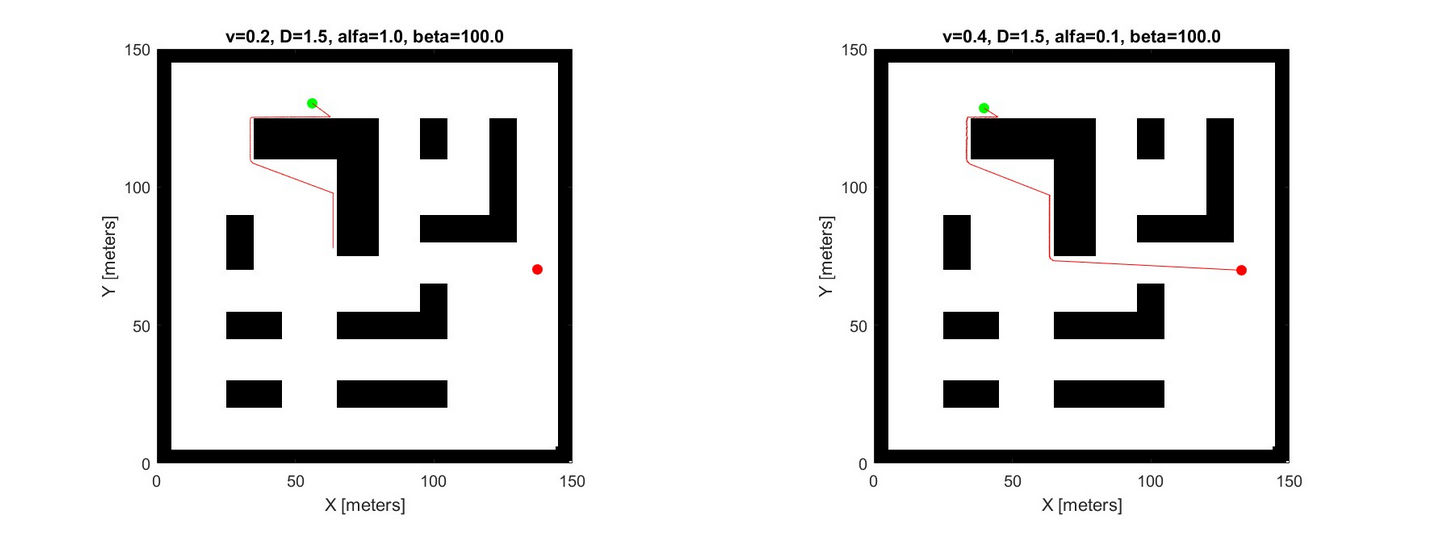


\newpage

### Trampa local

Si entre el origen y el destino se encuentra un obstáculo cóncavo

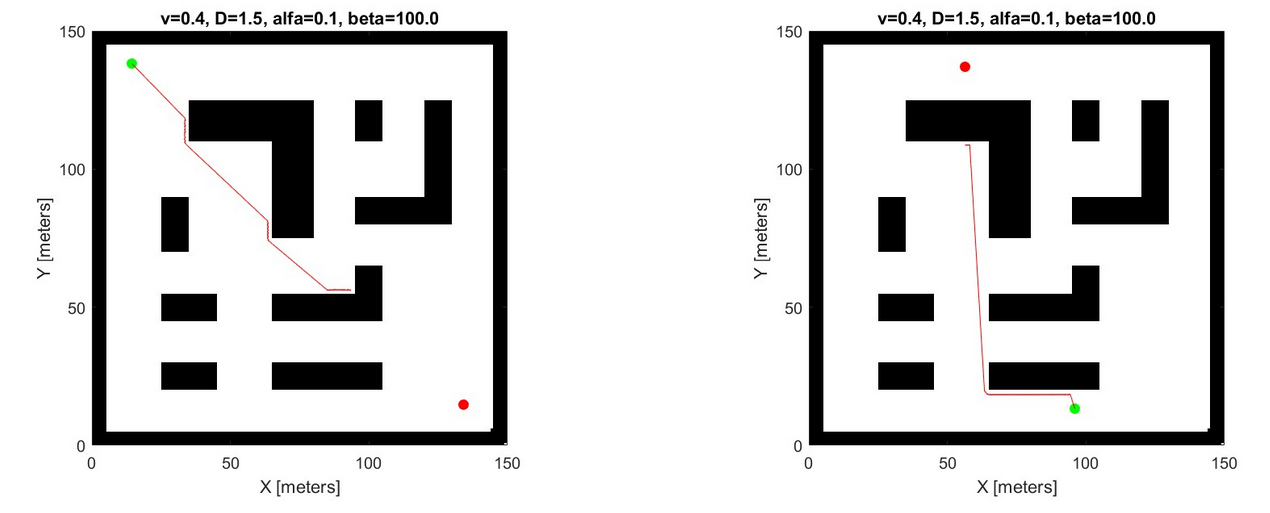

En esta situación, no importa qué parámetros se modifiquen porque no hay forma de evitarlo
